# Prepering Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Import Excel data and choose the relevant columns
df = pd.read_excel(r"C:\Users\noy\OneDrive - mail.tau.ac.il\פרויקט מעבדה\project_data.xlsx", sheet_name="the data")

# Ensure the DataFrame contains 'Occupation' and 'Anxiety Score' columns
df = df[['Occupation', 'Anxiety score']]

# Replace occupation names
df['Occupation'] = df['Occupation'].replace({
    'Health professions': 'Healthcare & Rescue Services',
    'Health Professions': 'Healthcare & Rescue Services',
    'rescue services': 'Healthcare & Rescue Services',
    'Science and Eng.': 'Science & Technology',
    'Information Technologies': 'Science & Technology',
    'HighTech': 'Science & Technology',
    'HIghTech': 'Science & Technology',
    'Machine professional': 'Science & Technology',
    'Business and finances': 'Business & Management',
    'Junior management': 'Business & Management',
    'Junior Management': 'Business & Management',
    'Senior Management': 'Business & Management',
    'Service and sales': 'Service & Sales',
    'Agriculture': 'Arts, Sports & Communication',
    'Sports': 'Arts, Sports & Communication',
    'Performing arts': 'Arts, Sports & Communication',
    'Design, craft & cooking': 'Arts, Sports & Communication',
    'journalism and translation': 'Arts, Sports & Communication',
    'Retired': 'Retired and Unemployed',
    'Unemployed': 'Retired and Unemployed',
    'government': 'Government',
})

# Remove rows with '#N/A' in 'Anxiety score'
df = df[df['Anxiety score'] != '#N/A']

# Drop rows with NaN values in 'Anxiety score' after conversion
df = df.dropna(subset=['Anxiety score'])

# Convert AnxietyScore to categorical
df['AnxietyScore'] = df['Anxiety score'].astype('category')

# Generating Correlations Plots

### Anxiety Score Distribution by Occupation

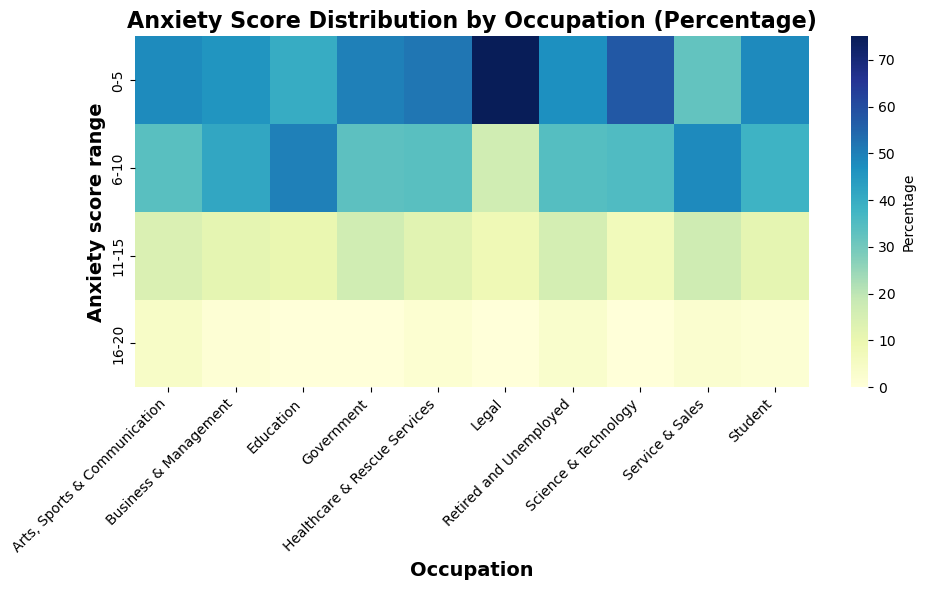

### Anxiety Score Distributions by 5 Most Pupular Occupations

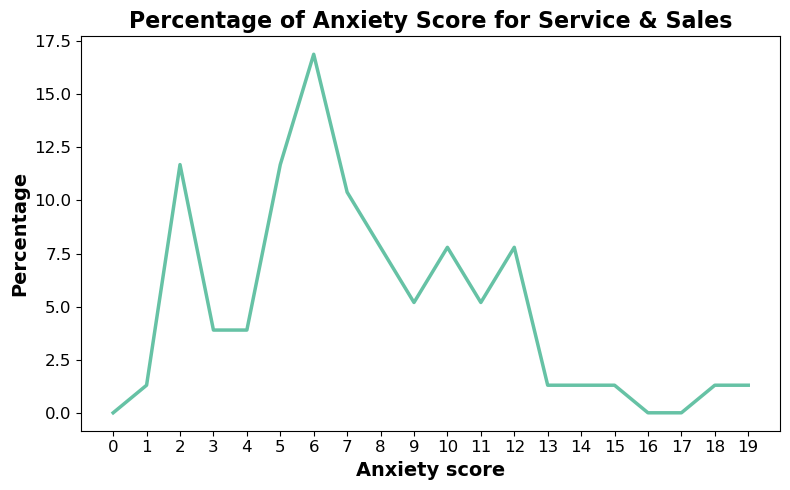

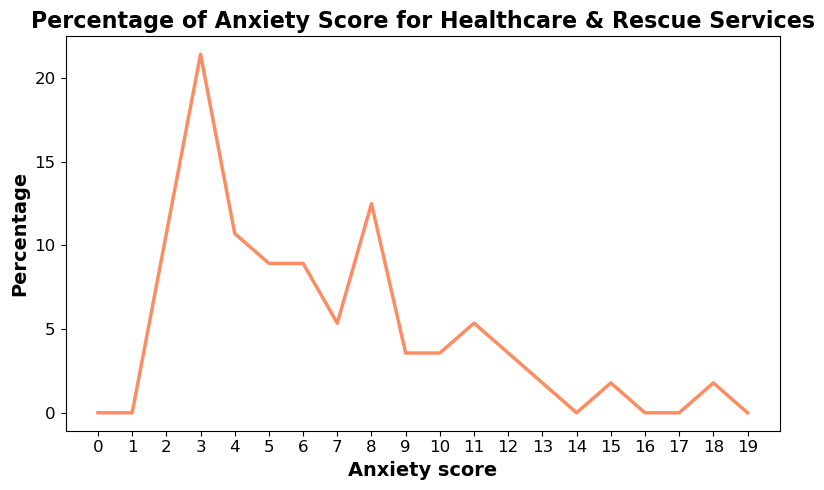

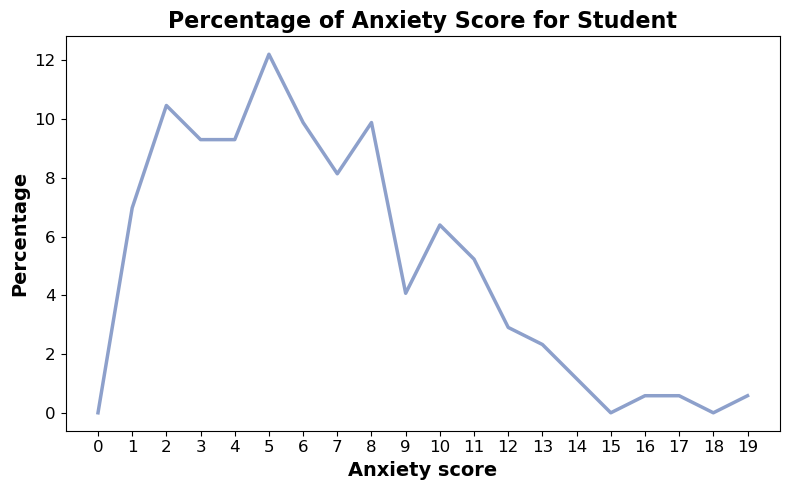

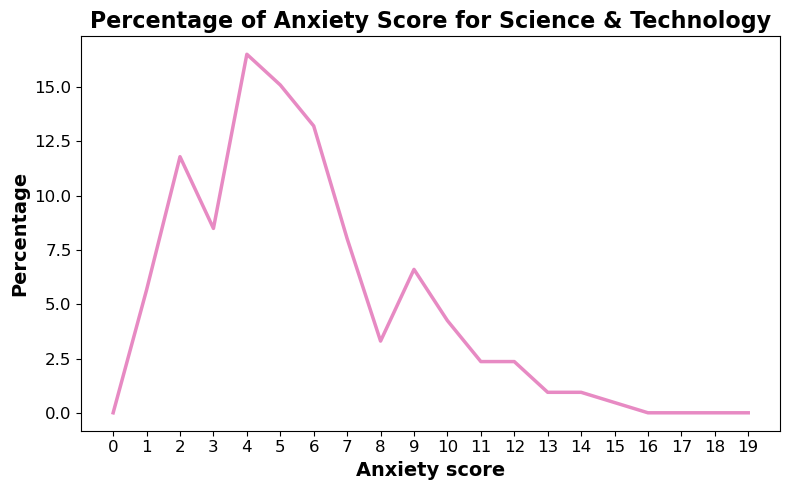

In [16]:
# Convert anxiety score to numeric if needed
df['Anxiety score'] = pd.to_numeric(df['Anxiety score'], errors='coerce')

# Merge anxiety bins into broader ranges (e.g., 0-5, 6-10, etc.)
df['Anxiety Bin'] = pd.cut(df['Anxiety score'], bins=[0, 5, 10, 15, 20], labels=['0-5', '6-10', '11-15', '16-20'])

# Create a pivot table to count the occurrences of each anxiety bin per occupation
heatmap_data = df.pivot_table(index='Anxiety Bin', columns='Occupation', aggfunc='size', fill_value=0)

# Convert counts to percentages
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the heatmap without annotations (numbers)
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Percentage'}, annot=False)

# Set title and labels
plt.title('Anxiety Score Distribution by Occupation (Percentage)', fontsize=16, fontweight='bold')
plt.xlabel('Occupation', fontsize=14, fontweight='bold')
plt.ylabel('Anxiety score range', fontsize=14, fontweight='bold')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Apply a tight layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

display(Markdown("### Anxiety Score Distributions by 5 Most Pupular Occupations"))

color_palette = sns.color_palette('Set2')

# Define the categories to plot
categories = {
    'Service & Sales': ['Service & Sales'],
    'Healthcare & Rescue Services': ['Healthcare & Rescue Services'],
    'Student': ['Student'],
    'Science & Technology': ['Science & Technology']
}

# Prepare data for plotting
x_values = list(range(20))  # Anxiety scores from 1 to 19

# Plot data for each category separately with smaller plots
for i, (category, occupations) in enumerate(categories.items()):
    plt.figure(figsize=(8, 5))  # Smaller figure size
    subset = df[df['Occupation'].isin(occupations)]
    means = subset.groupby('Anxiety score').size() / subset.shape[0] * 100
    means = means.reindex(x_values, fill_value=0)  # Ensure all Anxiety score from 1 to 19 are included
    plt.plot(x_values, means, color=color_palette[i], linestyle='-', linewidth=2.5, markersize=9)
    plt.title(f'Percentage of Anxiety Score for {category}', fontsize=16, fontweight='bold')
    plt.xlabel('Anxiety score', fontsize=14, fontweight='bold')
    plt.ylabel('Percentage', fontsize=14, fontweight='bold')
    plt.xticks(x_values, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Create a count table
count_df = df.groupby(['AnxietyScore', 'Occupation']).size().reset_index(name='Count')

# Performing ANOVA Test

In [3]:
# Perform ANOVA
model = ols('Count ~ C(Occupation) + C(AnxietyScore)', data=count_df).fit()
anova_table_raw = sm.stats.anova_lm(model, type=2)

def highlight_significant(p_value, threshold=0.05):
    color = 'background-color: #80aaff' if p_value < threshold else ''
    return color
anova_table_styled = anova_table_raw.style.applymap(highlight_significant, subset=['PR(>F)'])

display(Markdown("### ANOVA Results: Analyzing the Effect of Anxiety Score and Occupation"))
display(anova_table_styled)
print('Significant cells are highlighted in color.\n')

occupation_p_value = anova_table_raw.at['C(Occupation)', 'PR(>F)']
anxiety_score_p_value = anova_table_raw.at['C(AnxietyScore)', 'PR(>F)']

### ANOVA Results: Analyzing the Effect of Anxiety Score and Occupation

,df,sum_sq,mean_sq,F,PR(>F)
C(Occupation),9.000000,2125.663158,236.184795,16.185685,0.000000
C(AnxietyScore),18.000000,1923.642105,106.869006,7.323706,0.000000
Residual,162.000000,2363.936842,14.592203,nan,nan


Significant cells are highlighted in color.



# Performing Tukey's Test

In [4]:
# Perform Post Hoc tests
if occupation_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Occupation"))
    tukey_results_prof = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['Occupation'], alpha=0.05)
    tukey_results_prof_df = pd.DataFrame(tukey_results_prof.summary().data[1:], columns=tukey_results_prof.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == True]
    reject_false_df = tukey_results_prof_df[tukey_results_prof_df['reject'] == False]

    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

if anxiety_score_p_value < 0.05:
    display(Markdown("### Post-Hoc Test (Tukey's HSD) for Anxiety Score"))
    tukey_results_anxiety_score = pairwise_tukeyhsd(endog=count_df['Count'], groups=count_df['AnxietyScore'], alpha=0.05)
    tukey_results_anxiety_score_df = pd.DataFrame(tukey_results_anxiety_score.summary().data[1:], columns=tukey_results_anxiety_score.summary().data[0])
    
    # Filter results where reject is True and False
    reject_true_df = tukey_results_anxiety_score_df[tukey_results_anxiety_score_df['reject'] == True]
    reject_false_df = tukey_results_anxiety_score_df[tukey_results_anxiety_score_df['reject'] == False]
    
    def highlight_reject(val):
        return 'background-color: #80aaff' if val == True else ''

    if not reject_true_df.empty:
        reject_true_styled = reject_true_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = True:**"))
        display(reject_true_styled)
    else:
        display("No relevant cases for this scenario (Reject = True)")

    if not reject_false_df.empty:
        reject_false_styled = reject_false_df.style.applymap(highlight_reject, subset=['reject'])
        display(Markdown("**Reject = False:**"))
        display(reject_false_styled)
    else:
        display("No relevant cases for this scenario (Reject = False)")

### Post-Hoc Test (Tukey's HSD) for Occupation

**Reject = True:**

,group1,group2,meandiff,p-adj,lower,upper,reject
6,"Arts, Sports & Communication",Science & Technology,7.421100,0.000200,2.347900,12.494200,True
8,"Arts, Sports & Communication",Student,5.315800,0.031700,0.242600,10.389000,True
14,Business & Management,Science & Technology,7.473700,0.000200,2.400500,12.546800,True
16,Business & Management,Student,5.368400,0.028700,0.295300,10.441600,True
21,Education,Science & Technology,9.052600,0.000000,3.979500,14.125800,True
23,Education,Student,6.947400,0.000800,1.874200,12.020500,True
27,Government,Science & Technology,10.842100,0.000000,5.768900,15.915300,True
29,Government,Student,8.736800,0.000000,3.663700,13.810000,True
32,Healthcare & Rescue Services,Science & Technology,8.210500,0.000000,3.137400,13.283700,True
34,Healthcare & Rescue Services,Student,6.105300,0.006100,1.032100,11.178400,True


**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,"Arts, Sports & Communication",Business & Management,-0.052600,1.000000,-5.125800,5.020500,False
1,"Arts, Sports & Communication",Education,-1.631600,0.990000,-6.704700,3.441600,False
2,"Arts, Sports & Communication",Government,-3.421100,0.487800,-8.494200,1.652100,False
3,"Arts, Sports & Communication",Healthcare & Rescue Services,-0.789500,1.000000,-5.862600,4.283700,False
4,"Arts, Sports & Communication",Legal,-3.105300,0.627300,-8.178400,1.967900,False
5,"Arts, Sports & Communication",Retired and Unemployed,-2.052600,0.953400,-7.125800,3.020500,False
7,"Arts, Sports & Communication",Service & Sales,0.315800,1.000000,-4.757400,5.389000,False
9,Business & Management,Education,-1.578900,0.992100,-6.652100,3.494200,False
10,Business & Management,Government,-3.368400,0.510900,-8.441600,1.704700,False
11,Business & Management,Healthcare & Rescue Services,-0.736800,1.000000,-5.810000,4.336300,False


### Post-Hoc Test (Tukey's HSD) for Anxiety Score

**Reject = True:**

,group1,group2,meandiff,p-adj,lower,upper,reject
73,5.000000,13.000000,-8.500000,0.032600,-16.686600,-0.313400,True
74,5.000000,14.000000,-8.700000,0.024500,-16.886600,-0.513400,True
75,5.000000,15.000000,-9.500000,0.007200,-17.686600,-1.313400,True
76,5.000000,16.000000,-9.600000,0.006100,-17.786600,-1.413400,True
77,5.000000,17.000000,-9.600000,0.006100,-17.786600,-1.413400,True
78,5.000000,18.000000,-9.600000,0.006100,-17.786600,-1.413400,True
79,5.000000,19.000000,-9.700000,0.005200,-17.886600,-1.513400,True
88,6.000000,15.000000,-8.300000,0.042900,-16.486600,-0.113400,True
89,6.000000,16.000000,-8.400000,0.037400,-16.586600,-0.213400,True
90,6.000000,17.000000,-8.400000,0.037400,-16.586600,-0.213400,True


**Reject = False:**

,group1,group2,meandiff,p-adj,lower,upper,reject
0,1.000000,2.000000,4.500000,0.898100,-3.686600,12.686600,False
1,1.000000,3.000000,3.200000,0.996600,-4.986600,11.386600,False
2,1.000000,4.000000,4.000000,0.963100,-4.186600,12.186600,False
3,1.000000,5.000000,6.100000,0.439500,-2.086600,14.286600,False
4,1.000000,6.000000,4.900000,0.812000,-3.286600,13.086600,False
5,1.000000,7.000000,2.700000,0.999600,-5.486600,10.886600,False
6,1.000000,8.000000,0.900000,1.000000,-7.286600,9.086600,False
7,1.000000,9.000000,0.600000,1.000000,-7.586600,8.786600,False
8,1.000000,10.000000,0.400000,1.000000,-7.786600,8.586600,False
9,1.000000,11.000000,-0.800000,1.000000,-8.986600,7.386600,False
